In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv(open('train.csv','rb'))
test = pd.read_csv(open('test.csv','rb'))

In [2]:
#check for nan values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
# the age is sometimes not known, try fitting the data twice for the subsets with and without age
# I could do the same for 'Embarked', but this would only help for two entries, 
# so just remove them from training set
train = train[train['Embarked'].notnull()]

In [5]:
# for the one data point with missing fare, I simply replace its value with the median fare for the its Class
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [6]:
#the guy is Pclass 3
tmp = np.median(train.ix[train['Pclass']==3]['Fare'])
print(tmp)
test.loc[152,'Fare']=tmp

8.05


In [7]:
#first training with decision trees. I need to convert strings to numerical values 
#convert entries to numerical values in the Sex and Embarked feature
dic = {'male':0,'female':1,'S':0,'C':1,'Q':1}
train = train.replace(dic)
test = test.replace(dic)

In [8]:
#estimate age based on similarity to persons with know age
from sklearn.neighbors import KNeighborsRegressor

In [9]:
#can I do better, if I estimate nan-age entires based on other parameters, insetad of setting them to a default value?
#split of data set with correct ages
trainB = train[train['Age'].notnull()]
featuresB = ['Pclass','Sex','SibSp','Parch','Fare' ,'Embarked']
trainB2 = trainB[featuresB].values
yB = trainB['Age'].values
age_regressor = KNeighborsRegressor(weights='distance',n_neighbors=5)
age_regressor.fit(trainB2,yB)
yB_pred = age_regressor.predict(trainB2)

In [10]:
max(abs(yB_pred-yB))

39.600000000000001

In [11]:
np.median(abs(yB_pred-yB)) #about half the ages are estimated almost perfectly

1.4166666666666665

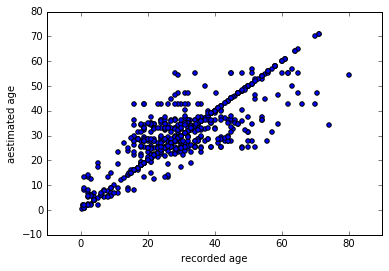

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure() #seems better than just defaulting on age
plt.scatter(yB,yB_pred)
plt.xlabel('recorded age')
plt.ylabel('aestimated age')

In [13]:
modify = train['Age'].isnull()
newvalues = age_regressor.predict(train.loc[modify,featuresB].values)
train.loc[modify,'Age']=newvalues

In [14]:
modify = test['Age'].isnull()
newvalues = age_regressor.predict(test.loc[modify,featuresB].values)
test.loc[modify,'Age']=newvalues

In [15]:
#I will only use Pclass,Sex,Age,SibSp,Parch,Fare and Embarked, switch to arrays
features = ['Pclass','Sex','Age','SibSp','Parch','Fare' ,'Embarked']
train2 = train[features].values
test2 = test[features].values
y = train['Survived'].values

In [16]:
# now try working with ensamble splitting
from sklearn.cross_validation import train_test_split
train3,calib3,ytrain3,ycalib3 = train_test_split(train2,y,test_size=0.3,random_state=0)

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=0)

In [18]:
tree.fit(train3,ytrain3)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [19]:
train_pred = tree.predict(train3)
calib_pred = tree.predict(calib3)

In [20]:
sum(train_pred==ytrain3)/len(ytrain3) #accuracy of fit

0.85530546623794212

In [21]:
sum(calib_pred==ycalib3)/len(ycalib3) #accuracy of prediction, max_depth = 4 gives best result

0.79026217228464424

In [22]:
from sklearn.tree import export_graphviz

In [23]:
export_graphviz(tree,out_file='tree.dot',feature_names=features)

In [24]:
%%bash
dot -Tpng tree.dot -o tree.png

In [25]:
#for the SVMs I need to rescale the data
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train4 = stdsc.fit_transform(train3)
calib4 = stdsc.transform(calib3)
test4 = stdsc.transform(test2)
ytrain4 = ytrain3
ycalib4 = ycalib3

In [41]:
# now try with SVM
from sklearn.svm import SVC
svm = SVC(kernel='linear',C=1,random_state=0)

In [42]:
svm.fit(train4,ytrain4)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
train_pred = svm.predict(train4)
calib_pred = svm.predict(calib4)

In [44]:
sum(train_pred==ytrain4)/len(ytrain4) #accuracy of fit

0.79903536977491962

In [45]:
sum(calib_pred==ycalib4)/len(ycalib4) #play with regularization, C=0.1...10 does not have a big influence

0.77153558052434457

In [108]:
svm = SVC(kernel='rbf',C=10,random_state=0,gamma=0.1)
svm.fit(train4,ytrain4)
train_pred = svm.predict(train4)
calib_pred = svm.predict(calib4)

In [109]:
sum(train_pred==ytrain4)/len(ytrain4) #accuracy of fit

0.86977491961414788

In [110]:
sum(calib_pred==ycalib4)/len(ycalib4) 
#optimized C and gamma for this value

0.79400749063670417

In [114]:
### try random forest 
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',n_estimators=9,random_state=1,n_jobs=3)
forest.fit(train3,ytrain3)
train_pred = forest.predict(train3)
calib_pred = forest.predict(calib3)

In [115]:
sum(train_pred==ytrain3)/len(ytrain3) #accuracy of fit

0.9662379421221865

In [116]:
sum(calib_pred==ycalib3)/len(ycalib3) #Moptimized estimators

0.80149812734082393

In [145]:
#try nearest neighbour
from sklearn.neighbors import KNeighborsClassifier
neighbour = KNeighborsClassifier(weights='distance',n_neighbors=5)
neighbour.fit(train3,ytrain3)
train_pred = forest.predict(train3)
calib_pred = forest.predict(calib3)

In [146]:
sum(train_pred==ytrain3)/len(ytrain3) #accuracy of fit

0.9662379421221865

In [147]:
sum(calib_pred==ycalib3)/len(ycalib3) #optimized estimators

0.80149812734082393

In [167]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100,random_state=0)
lr.fit(train4,ytrain4)
train_pred = lr.predict(train4)
calib_pred = lr.predict(calib4)

In [168]:
sum(train_pred==ytrain4)/len(ytrain4) #accuracy of fit

0.82154340836012862

In [169]:
sum(calib_pred==ycalib4)/len(ycalib4) 

0.77153558052434457

In [209]:
from sklearn.preprocessing import PolynomialFeatures
quadratic = PolynomialFeatures(degree=2)
train4p = quadratic.fit_transform(train4)
calib4p = quadratic.fit_transform(calib4)
lr = LogisticRegression(C=0.01,random_state=0)
lr.fit(train4p,ytrain4)
train_pred = lr.predict(train4p)
calib_pred = lr.predict(calib4p)

In [210]:
sum(train_pred==ytrain4)/len(ytrain4) #accuracy of fit

0.842443729903537

In [211]:
sum(calib_pred==ycalib4)/len(ycalib4) 

0.80524344569288386

In [212]:
#use random forest classifier, but now on full data set
forest = RandomForestClassifier(criterion='entropy',n_estimators=9,random_state=1,n_jobs=3)
forest.fit(train2,y)
train_pred = forest.predict(train2)
test_pred = forest.predict(test2)

In [213]:
sum(train_pred==y)/len(y) #accuracy of fit

0.95950506186726658

In [214]:
output = pd.DataFrame()
output['PassengerId']=test['PassengerId'].values
test_pred = forest.predict(test2)
output['Survived']= test_pred
output.to_csv('myforest.csv', sep=',',index=False)

In [216]:
sum(test_pred)

162